Dask Distributed
=========================

This notebook shows how to deal with a big volume of data in a cluster. In my case the "cluster" is just two laptops and a desktop PC, with a wired network connection.

The first question to ask is how to load the data into the cluster. In my case I have only a few machines, but not the best network connections, so I opted for a ZARR archive I have manually copied to each machine. In a datacenter or a cloud cluster, it would be better to use either NFS, S3 or another solution, all of which are supported by Dask. But "local" file access was fastest in my case.

In [11]:
import numpy as np
import scipy as sp
import scipy.misc
import dask
import dask.array as da
import skimage.io
import zarr
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from distributed import Client
%matplotlib inline

The Client object represents our connection to the Dask scheduler. We use that to submit tasks.

In [2]:
client = Client('192.168.178.45:8786')

For the first transfer from disk to Dask Arrays we need two functions. One gives us info about the archive, the other loads an individual chunk. These functions will be invoked on the cluster's nodes by the scheduler.

In [3]:
@dask.delayed
def get_zarr_info(f):
    import zarr
    a = zarr.open(f, mode="r")
    return dict(shape=a.shape, info=a.info, chunks=a.chunks)
@dask.delayed
def get_chunk(f, x,y,z):
    a = zarr.open(fname, mode="r")
    cx,cy,cz = a.chunks
    return a[cx*x:cx*(x+1), cy*y:cy*(y+1), cz*z:cz*(z+1)]

The setup is extremely simple, all the machines have the ZARR archive at the same path.

In [4]:
fname = '/home/andi/imaging/demo/chameleon/chameleon.zarr'
f = client.compute(dask.delayed(get_zarr_info(fname)))
zarr_info = client.gather(f)
size = zarr_info['shape']
chunk_size = zarr_info['chunks']
print ("size", size)
print ("chunksize", chunk_size)

size (1536, 1219, 1645)
chunksize (100, 100, 100)


The next part is a bit more complicated, because the different chunks need to be assembled in the right shape. Note that this code mostly creates a whole bunch of Dask tasks, which are not yet executed.

In [5]:
def prep_chunk(i,j,k):
    xs = chunk_size[0]
    if (i+1)*xs>size[0]:
        xs = size[0]-i*xs
    ys = chunk_size[1]
    if (j+1)*ys>size[1]:
        ys = size[1]-j*ys
        
    zs = chunk_size[2]
    if (k+1)*ys>size[2]:
        zs = size[2]-k*zs

    return da.from_delayed(get_chunk(fname, int(i),int(j),int(k)), shape=(xs,ys, zs), dtype=np.uint16)


l = [[[prep_chunk(i,j, k)
         for k in np.arange(np.floor(size[0]/chunk_size[0]))]
          for j in np.arange(np.floor(size[1]/chunk_size[1]))]
            for i in np.arange(np.floor(size[2]/chunk_size[2]))]
vol = da.block(l)

In [6]:
%%time
f = client.compute(vol.max(axis=1).clip(7000,18000))
img = f.result()

CPU times: user 3.71 s, sys: 296 ms, total: 4.01 s
Wall time: 33.2 s


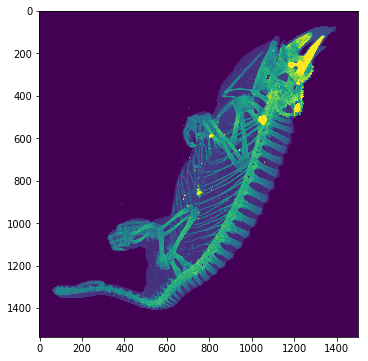

In [7]:
f,ax = plt.subplots()
f.set_figwidth(6)
f.set_figheight(6)
ax.imshow(img);

CPU times: user 323 ms, sys: 47.9 ms, total: 371 ms
Wall time: 1.65 s


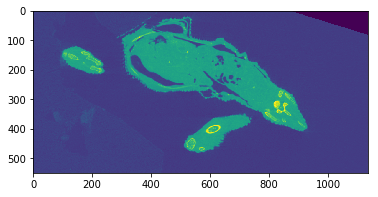

In [9]:
%%time
f = client.compute(vol[400:,150:700,700])
img = f.result()
f,ax = plt.subplots()
f.set_figwidth(6)
f.set_figheight(6)
ax.imshow(img.clip(0,14000).transpose());

For certain image operations it's not enough to look at an individual pixel. If, for example, a gaussian filter needs to look at surrounding pixels, these pixels need to be inside the chunk currently processed, otherwise there will be artifacts in the final results. Dask array provides the "ghost" function for these cases, which allows you to define overlapping chunks.

In [12]:
def g_filter(block):
    return gaussian_filter(block, 3)
d = 3
depth={0:d,1:d,2:d}
g = da.ghost.ghost(vol, depth=depth, boundary=0)
g2 = g.map_blocks(g_filter)
vol2 = da.ghost.trim_internal(g2, depth)

In [13]:
%%time
f = client.compute(vol2.sum(axis=0))
img = f.result()

CPU times: user 55.4 s, sys: 6.55 s, total: 1min 1s
Wall time: 5min 47s


In [14]:
%%time
f = client.compute(vol2.mean(axis=0)[100:600,100:600])
img = f.result()

CPU times: user 8.93 s, sys: 1.83 s, total: 10.8 s
Wall time: 2min 4s


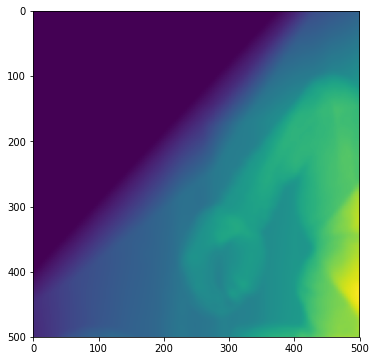

In [15]:
f,ax = plt.subplots()
f.set_figwidth(6)
f.set_figheight(6)
ax.imshow(img);

In [16]:
f = client.compute(vol2[:,400,:])
img = f.result()

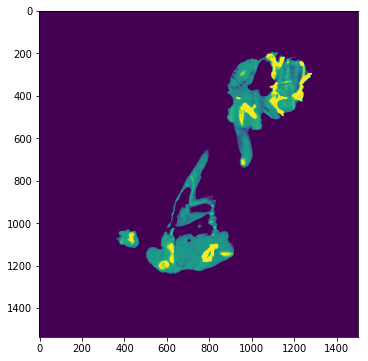

In [17]:
f,ax = plt.subplots()
f.set_figwidth(6)
f.set_figheight(6)
ax.imshow(img.clip(6000,10000));

In [18]:
%%time
bins,h = da.histogram(vol, bins=1000, range=[0, 12000])
bins = bins.compute()

CPU times: user 5.08 s, sys: 175 ms, total: 5.26 s
Wall time: 29 s


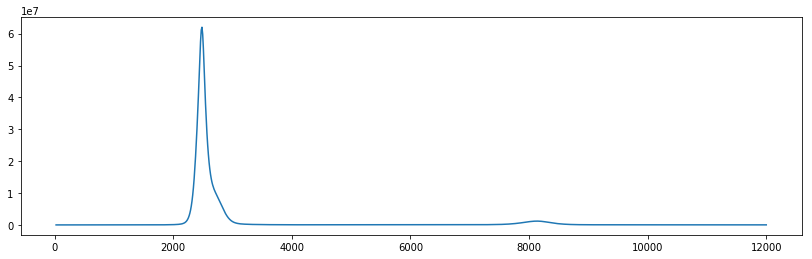

In [19]:
f, ax = plt.subplots()
f.set_figwidth(14)
ax.plot(h[2:], bins[1:]);